<a href="https://colab.research.google.com/github/SLPcourse/CSC3160-120090195-ChengYang/blob/main/RoBERTa_Attribution_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json

import torch
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

from google.colab import drive
drive.mount('/content/drive')

# Definition of a custom dataset for the sequence classification task
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, tokenizer, max_length=512):
        self.inputs = inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Return the number of examples in the dataset
    def __len__(self):
        return len(self.inputs)

    # Return a single example and its corresponding label
    def __getitem__(self, index):
        input_ids = self.tokenizer.encode(
            self.inputs[index], add_special_tokens=True, max_length=self.max_length
        )
        label = self.labels[index]
        return input_ids, label


# Definition of a model trainer for the sequence classification task
class ModelTrainer:
    def __init__(
        self,
        train_file,
        val_file,
        test_file,
        model_name="roberta-base",
        batch_size=8,
        num_epochs=1,
        learning_rate=2e-5,
        warmup_steps=0.1,
    ):
        # Load the training, validation, and test data from JSON files
        self.train_data = self.load_data(train_file)
        self.val_data = self.load_data(val_file)
        self.test_data = self.load_data(test_file)
        # Instantiate a tokenizer and a pre-trained model for sequence classification
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaForSequenceClassification.from_pretrained(model_name).cuda()
        # Set the batch size, number of epochs, loss function, optimizer, and learning rate scheduler
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(warmup_steps * len(self.train_data) / self.batch_size),
            num_training_steps=len(self.train_data)
            * self.num_epochs
            // self.batch_size,
        )

    # Load data from a JSON file and return a list of examples
    def load_data(self, filepath):
        with open(filepath, "r") as f:
            data = json.load(f)
        examples = []
        for example in data:
            text = example["text"]
            label = example["fake"]
            examples.append({"text": text, "label": label})
        return examples

    # Tokenize the inputs and labels and return them as two lists
    def tokenize_inputs(self, data):
        inputs = []
        labels = []
        for example in data:
            input_ids = self.tokenizer.encode(
                example["text"],
                add_special_tokens=True,
                truncation=True,
                max_length=512,
            )
            inputs.append(input_ids)
            labels.append(example["label"])
        return inputs, labels

    # Function to pad input sequences and return them in a batch
    def collate_fn(self, batch):
        input_ids = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        # Get the maximum length of the input sequences in the batch
        max_length = max(len(ids) for ids in input_ids)
        input_ids_padded = []
        attention_masks = []
        # Pad the input sequences and create attention masks
        for ids in input_ids:
            padding = [0] * (max_length - len(ids))
            input_ids_padded.append(ids + padding)
            attention_masks.append([1] * len(ids) + padding)
        # Return the inputs and labels as a dictionary and a tensor, respectively
        inputs = {
            "input_ids": torch.tensor(input_ids_padded),
            "attention_mask": torch.tensor(attention_masks),
        }
        return inputs, torch.tensor(labels)

    # Train the model on a given dataloader
    def train_model(self, train_loader):
        # Set the model to training mode and initialize the total loss
        self.model.train()
        total_loss = 0.0
        pbar = tqdm(total=len(train_loader))
        # Iterate over the batches in the dataloader
        for step, (inputs, labels) in enumerate(train_loader, start=1):
            # Clear the gradients, get the model outputs, and calculate the loss
            self.optimizer.zero_grad()
            outputs = self.model(
                inputs["input_ids"].cuda(),
                attention_mask=inputs["attention_mask"].cuda(),
            )
            loss = self.criterion(outputs.logits, labels.cuda())
            # Backpropagate the loss, update the parameters, and adjust the learning rate
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            # Update the total loss and calculate the average loss
            total_loss += loss.item()
            avg_loss = total_loss / step
            # Update the progress bar
            pbar.set_description(f"avg_loss: {avg_loss:.4f}")
            pbar.update(1)
        pbar.close()
        # Return the average loss over the entire dataset
        return total_loss / len(train_loader)

    # Evaluate the model on a given dataloader
    def evaluate_model(self, test_loader):
        # Set the model to evaluation mode and initialize the true and predicted labels
        self.model.eval()
        true_labels = []
        predicted_labels = []
        with torch.no_grad():
            # Iterate over the batches in the dataloader and get the model outputs
            for inputs, labels in test_loader:
                outputs = self.model(
                    inputs["input_ids"].cuda(),
                    attention_mask=inputs["attention_mask"].cuda(),
                )
                # Append the true and predicted labels to their respective lists
                true_labels.extend(labels)
                predicted_labels.extend(torch.argmax(outputs.logits, dim=1).cpu())
        # Calculate the classification report and the accuracy of the model
        report = classification_report(true_labels, predicted_labels, digits=4)
        return (
            report,
            torch.sum(torch.tensor(true_labels) == torch.tensor(predicted_labels))
            / len(true_labels),
        )

    # Train and evaluate the model for a given number of epochs
    def run_training(self):
        # Tokenize the inputs and labels for the training, validation, and test datasets
        train_inputs, train_labels = self.tokenize_inputs(self.train_data)
        val_inputs, val_labels = self.tokenize_inputs(self.val_data)
        test_inputs, test_labels = self.tokenize_inputs(self.test_data)

        # Create dataloaders for the training, validation, and test datasets
        train_dataset = CustomDataset(train_inputs, train_labels, self.tokenizer)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )
        val_dataset = CustomDataset(val_inputs, val_labels, self.tokenizer)
        val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn
        )
        test_dataset = CustomDataset(test_inputs, test_labels, self.tokenizer)
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn
        )

        # Train the model for a given number of epochs and save the best model based on the validation accuracy
        best_accuracy = 0
        for epoch in range(self.num_epochs):
            train_loss = self.train_model(train_loader)
            val_report, val_accuracy = self.evaluate_model(val_loader)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(self.model.state_dict(), "best_model.pt")
            # Print the epoch number, training loss, and validation accuracy
            print(
                f"Epoch {epoch + 1}, train loss: {train_loss:.4f}, val accuracy: {val_accuracy:.4f}"
            )
            # Print the classification report for the validation dataset
            print(val_report)
        # Load the best model based on the validation accuracy and evaluate it on the test dataset
        self.model.load_state_dict(torch.load("best_model.pt"))
        test_report, test_accuracy = self.evaluate_model(test_loader)
        # Print the best accuracy and the classification report for the test dataset
        print(f"Best accuracy: {test_accuracy:.4f}")
        print(test_report)


if __name__ == "__main__":
    trainer = ModelTrainer(
        "/content/drive/MyDrive/train.json", "/content/drive/MyDrive/val.json", "/content/drive/MyDrive/test.json"
    )
    trainer.run_training()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Streaming output truncated to the last 5000 lines.
avg_loss: 0.0252: 100%|██████████| 7691/7691 [19:22<00:00,  6.62it/s]


Epoch 1, train loss: 0.0252, val accuracy: 0.9985
              precision    recall  f1-score   support

           0     0.9998    0.9981    0.9989      4654
           1     0.9959    0.9995    0.9977      2182

    accuracy                         0.9985      6836
   macro avg     0.9978    0.9988    0.9983      6836
weighted avg     0.9985    0.9985    0.9985      6836

Best accuracy: 0.9975
              precision    recall  f1-score   support

           0     0.9997    0.9967    0.9982     11720
           1     0.9928    0.9994    0.9961      5370

    accuracy                         0.9975     17090
   macro avg     0.9963    0.9981    0.9972     17090
weighted avg     0.9976    0.9975    0.9975     17090



In [ ]:
# Import required libraries
import numpy as np
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer



def load_model(model_path):
    # Load the tokenizer and model from the "roberta-base" pre-trained model
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaForSequenceClassification.from_pretrained("roberta-base").cuda()

    # Load the saved state dict of the fine-tuned model
    model.load_state_dict(torch.load(model_path))

    return tokenizer, model


def preprocess_text(tokenizer, input_text, max_length):
    # Tokenize the input text using the tokenizer
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=max_length,
        truncation=True,
    )

    # Get the input_ids and attention_mask tensors
    return inputs["input_ids"].cuda(), inputs["attention_mask"].cuda()


def get_prediction(model, input_ids, attention_mask):
    # Get the predicted label using the input_ids and attention_mask
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted_label = np.argmax(outputs.logits.detach().cpu().numpy())
    return predicted_label


def main():
    # Load the fine-tuned model from the saved state dict
    model_path = "/content/drive/MyDrive/best_model.pt"
    tokenizer, model = load_model(model_path)

    # Get the test sentence from the file
    with open("/content/drive/MyDrive/text_test.txt", encoding="utf-8", mode="r") as fr:
        lines = fr.readlines()
        for line in lines:
            test_sentence = line.strip()
            # Preprocess the test sentence and get the predicted label
            input_ids, attention_mask = preprocess_text(
                tokenizer, test_sentence, max_length=512
            )
            predicted_label = get_prediction(model, input_ids, attention_mask)

            # Print the output based on the predicted label
            if predicted_label == 0:
                print("human")
            else:
                print("chatGPT")


if __name__ == "__main__":
    main()


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

chatGPT
chatGPT
human


In [ ]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
class Model_Wrapper(torch.nn.Module):
    def __init__(self):
        super(Model_Wrapper, self).__init__()
        self.tokenizer,self.model = load_model("/content/drive/MyDrive/best_model.pt")
    
    def get_embeddings(self, input_ids):
        return self.model.roberta.embeddings(input_ids)
    
    def forward(self, embeddings):        
        encoder_outputs = self.model.roberta.encoder(embeddings)
        sequence_output = encoder_outputs[0]
#         pooled_output = self.model.roberta.pooler(sequence_output) if self.model.roberta.pooler is not None else None
#         roberta_outputs = (sequence_output, pooled_output) + encoder_outputs[1:]
        
        logits = self.model.classifier(sequence_output)
#         print(f'logits {logits} {logits.size()} {logits.dtype} {logits.requires_grad}')
        pred_prob = torch.softmax(logits, dim=1)[:, 1]
        #get the item at idx 1 because it corresponds to probability of being positive
        
        return pred_prob

In [ ]:
from captum.attr import DeepLift
model_attribution = Model_Wrapper()
deep_lift = DeepLift(model_attribution)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
def explainer(text):
  tokenized = tokenizer(text,truncation=True)
  input_ids = torch.tensor(tokenized['input_ids']).unsqueeze(0)
  input_emb = model.roberta.embeddings(input_ids.cuda())
  attribution, delta = deep_lift.attribute(input_emb, return_convergence_delta=True)
  word_attributions = attribution.squeeze(0).sum(dim=1)
  word_attributions /= torch.norm(word_attributions)
  attribution_list = word_attributions.detach().tolist()
  attr_score = torch.sum(word_attributions)
  detokenized = [t.replace('Ġ', '') for t in tokenizer.convert_ids_to_tokens(input_ids[0])]
  word_importance = []
  for i in range(len(detokenized)):
    temp = (detokenized[i],round(attribution_list[i],3))
    word_importance.append(temp)
  return word_importance

# **Calculate the sentiment score for word level and sentence level.**

In [ ]:
pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from afinn import Afinn
afinn = Afinn()
# Calculate sentiment score for a single string
text = 'amazing'
score = afinn.score(text)/5
print(score)  # Output: 3.0

0.8


# **Get the part of speech for a single word**

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

data = pos_tag(word_tokenize("John's big idea isn't all that bad."), tagset='universal')
df = pd.DataFrame.from_records(
    data, columns=['Word', 'Part of Speech'])
df
  

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Word,Part of Speech
0,John,NOUN
1,'s,PRT
2,big,ADJ
3,idea,NOUN
4,is,VERB
5,n't,ADV
6,all,DET
7,that,DET
8,bad,ADJ
9,.,.


In [ ]:
df['Sentiment'] = df['Word'].apply(afinn.score)/5

In [ ]:
df

,Word,Part of Speech,Sentiment
0,John,NOUN,0.0
1,'s,PRT,0.0
2,big,ADJ,0.2
3,idea,NOUN,0.0
4,is,VERB,0.0
5,n't,ADV,0.0
6,all,DET,0.0
7,that,DET,0.0
8,bad,ADJ,-0.6
9,.,.,0.0


# **Token Levle Analysis**

**Attribution Analysis about Sentiment & Part of Speech**

In [ ]:
def load_data_GPT(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    examples = []
    for example in data:
        text = example["text"]
        label = example["fake"]
        if int(label) == 1: 
          examples.append(text)
    return examples

In [ ]:
def load_data_Human(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    examples = []
    for example in data:
        text = example["text"]
        label = example["fake"]
        if int(label) == 0: 
          examples.append(text)
    return examples

In [ ]:
GPT_text = load_data_GPT('/content/drive/MyDrive/train.json')[:500]

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline
from afinn import Afinn
afinn = Afinn()
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)
df_attribution = pd.DataFrame(dtype='float16')

for text in GPT_text:
    explanation = explainer(text)
    temp = pd.DataFrame.from_records(explanation, columns=['Word', 'Attribution Score'])
    df_attribution = pd.concat([df_attribution,temp])

df_attribution['Sentiment'] = df_attribution['Word'].apply(afinn.score)/5

df_PartOfSpeech = pd.DataFrame()


for text in GPT_text:
    test_sentence = text.strip()
    data = pos_tag(word_tokenize(test_sentence), tagset='universal')
    temp = pd.DataFrame.from_records(data, columns=['Word', 'Part of Speech'])
    df_PartOfSpeech = pd.concat([df_PartOfSpeech,temp])




In [ ]:
df_attribution

,Word,Attribution Score,Sentiment
0,<s>,0.072,0.0
1,Sure,-0.025,0.0
2,!,-0.026,0.0
3,A,0.015,0.0
4,speaker,0.008,0.0
...,...,...,...
87,while,0.031,0.0
88,watching,-0.042,0.0
89,movies,-0.020,0.0
90,.,0.038,0.0


In [ ]:
df_PartOfSpeech

,Word,Part of Speech
0,Sure,ADV
1,!,.
2,A,DET
3,speaker,NOUN
4,is,VERB
...,...,...
81,enjoy,VERB
82,while,ADP
83,watching,VERB
84,movies,NOUN


In [ ]:
test = pd.merge(df_attribution,df_PartOfSpeech,how='inner',on='Word',copy=False)
test = test.drop_duplicates()

In [ ]:
test

,Word,Attribution Score,Sentiment,Part of Speech
0,Sure,-0.025,0.0,ADV
4,Sure,-0.025,0.0,ADJ
20,Sure,-0.093,0.0,ADV
24,Sure,-0.093,0.0,ADJ
40,Sure,-0.047,0.0,ADV
...,...,...,...,...
96510984,popcorn,-0.001,0.0,VERB
96510985,popcorn,-0.001,0.0,NOUN
96510986,popcorn,0.109,0.0,VERB
96510987,popcorn,0.109,0.0,NOUN


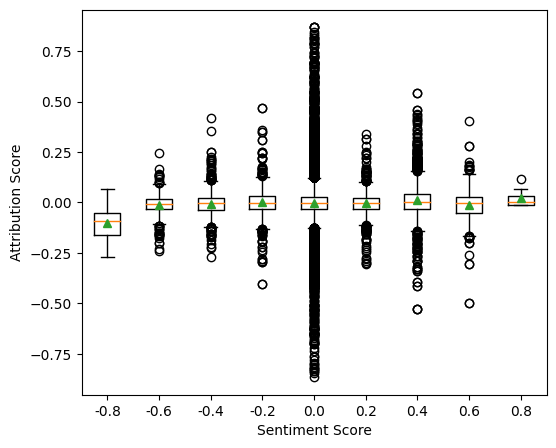

In [ ]:
# GPT Sentiment Box Plot
box1 = test[test['Sentiment']==-0.8]['Attribution Score']
box2 = test[test['Sentiment']==-0.6]['Attribution Score']
box3 = test[test['Sentiment']==-0.4]['Attribution Score']
box4 = test[test['Sentiment']==-0.2]['Attribution Score']
box5 = test[test['Sentiment']==0.0]['Attribution Score']
box6 = test[test['Sentiment']==0.2]['Attribution Score']
box7 = test[test['Sentiment']==0.4]['Attribution Score']
box8 = test[test['Sentiment']==0.6]['Attribution Score']
box9 = test[test['Sentiment']==0.8]['Attribution Score']



plt.figure(figsize=(6,5))
labels = '-0.8','-0.6','-0.4','-0.2','0.0','0.2','0.4','0.6','0.8'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9],labels = labels,showmeans=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Attribution Score')
plt.show()

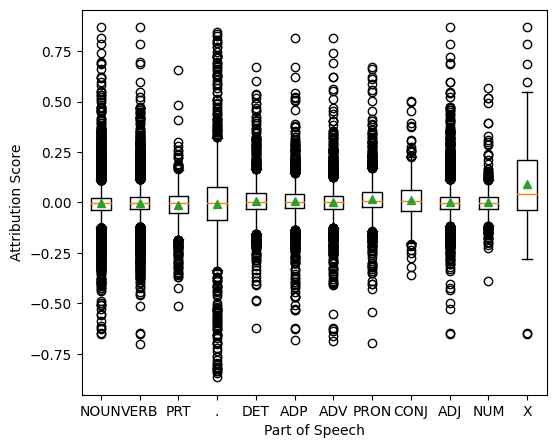

In [ ]:
# GPT Patr of Specch Box Plot
box1 = test[test['Part of Speech']=='NOUN']['Attribution Score']
box2 = test[test['Part of Speech']=='VERB']['Attribution Score']
box3 = test[test['Part of Speech']=='PRT']['Attribution Score']
box4 = test[test['Part of Speech']=='.']['Attribution Score']
box5 = test[test['Part of Speech']=='DET']['Attribution Score']
box6 = test[test['Part of Speech']=='ADP']['Attribution Score']
box7 = test[test['Part of Speech']=='ADV']['Attribution Score']
box8 = test[test['Part of Speech']=='PRON']['Attribution Score']
box9 = test[test['Part of Speech']=='CONJ']['Attribution Score']
box10 = test[test['Part of Speech']=='ADJ']['Attribution Score']
box11 = test[test['Part of Speech']=='NUM']['Attribution Score']
box12 = test[test['Part of Speech']=='X']['Attribution Score']

plt.figure(figsize=(6,5))
labels = 'NOUN','VERB','PRT','.','DET','ADP','ADV','PRON','CONJ','ADJ','NUM','X'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9,box10,box11,box12],labels = labels,showmeans=True)
plt.xlabel('Part of Speech')
plt.ylabel('Attribution Score')
plt.show()


In [ ]:
Human_text = load_data_Human('/content/drive/MyDrive/train.json')[:500]

In [ ]:
afinn = Afinn()
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)
df_attribution = pd.DataFrame(dtype='float16')

for text in Human_text:
    explanation = explainer(text)
    temp = pd.DataFrame.from_records(explanation, columns=['Word', 'Attribution Score'])
    df_attribution = pd.concat([df_attribution,temp])

df_attribution['Sentiment'] = df_attribution['Word'].apply(afinn.score)/5

df_PartOfSpeech = pd.DataFrame()


for text in Human_text:
    test_sentence = text.strip()
    data = pos_tag(word_tokenize(test_sentence), tagset='universal')
    temp = pd.DataFrame.from_records(data, columns=['Word', 'Part of Speech'])
    df_PartOfSpeech = pd.concat([df_PartOfSpeech,temp])

In [ ]:
test = pd.merge(df_attribution,df_PartOfSpeech,how='inner',on='Word',copy=False)
test = test.drop_duplicates()

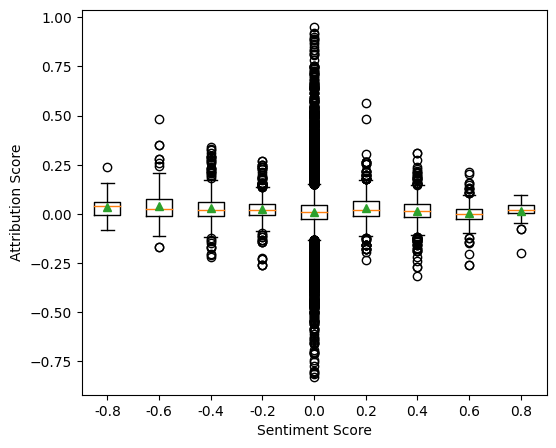

In [ ]:
# Human Sentiment Box Plot
box1 = test[test['Sentiment']==-0.8]['Attribution Score']
box2 = test[test['Sentiment']==-0.6]['Attribution Score']
box3 = test[test['Sentiment']==-0.4]['Attribution Score']
box4 = test[test['Sentiment']==-0.2]['Attribution Score']
box5 = test[test['Sentiment']==0.0]['Attribution Score']
box6 = test[test['Sentiment']==0.2]['Attribution Score']
box7 = test[test['Sentiment']==0.4]['Attribution Score']
box8 = test[test['Sentiment']==0.6]['Attribution Score']
box9 = test[test['Sentiment']==0.8]['Attribution Score']

plt.figure(figsize=(6,5))
labels = '-0.8','-0.6','-0.4','-0.2','0.0','0.2','0.4','0.6','0.8'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9],labels = labels,showmeans=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Attribution Score')
plt.show()

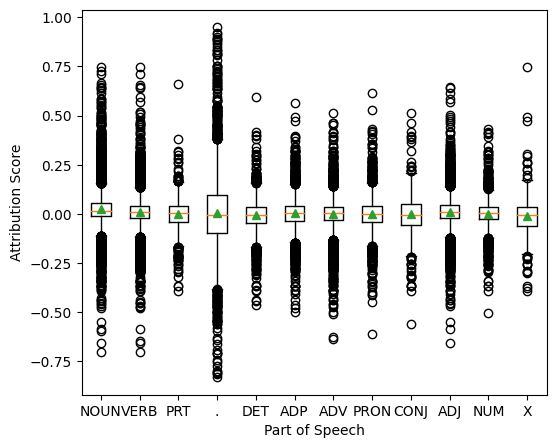

In [ ]:
# Human Part of Speech Box Plot
box1 = test[test['Part of Speech']=='NOUN']['Attribution Score']
box2 = test[test['Part of Speech']=='VERB']['Attribution Score']
box3 = test[test['Part of Speech']=='PRT']['Attribution Score']
box4 = test[test['Part of Speech']=='.']['Attribution Score']
box5 = test[test['Part of Speech']=='DET']['Attribution Score']
box6 = test[test['Part of Speech']=='ADP']['Attribution Score']
box7 = test[test['Part of Speech']=='ADV']['Attribution Score']
box8 = test[test['Part of Speech']=='PRON']['Attribution Score']
box9 = test[test['Part of Speech']=='CONJ']['Attribution Score']
box10 = test[test['Part of Speech']=='ADJ']['Attribution Score']
box11 = test[test['Part of Speech']=='NUM']['Attribution Score']
box12 = test[test['Part of Speech']=='X']['Attribution Score']

plt.figure(figsize=(6,5))
labels = 'NOUN','VERB','PRT','.','DET','ADP','ADV','PRON','CONJ','ADJ','NUM','X'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9,box10,box11,box12],labels = labels,showmeans=True)
plt.xlabel('Part of Speech')
plt.ylabel('Attribution Score')
plt.show()




**Avaerage Sentiment Score for each token**

In [ ]:
GPT_text = load_data_GPT('/content/drive/MyDrive/train.json')
Human_text = load_data_Human('/content/drive/MyDrive/train.json')
print(len(GPT_text))
print(len(Human_text))

19351
42172


In [ ]:
from afinn import Afinn
afinn = Afinn()

word_list = []
for text in GPT_text:
  temp = text.split(' ')
  word_list = word_list + temp
sentiment_df = pd.DataFrame({'Word':word_list})

sentiment_df['Sentiment'] = sentiment_df['Word'].apply(afinn.score)/5

In [ ]:
sentiment_df['Sentiment'].mean()

0.005845255451712465

In [ ]:
word_list_Human = []
for text in Human_text[:10000]:
  temp = text.split(' ')
  word_list_Human = word_list_Human + temp
sentiment_df_Human = pd.DataFrame({'Word':word_list_Human})

sentiment_df_Human['Sentiment'] = sentiment_df_Human['Word'].apply(afinn.score)/5

In [ ]:
sentiment_df_Human['Sentiment'].mean()

0.00151088386921964

**Proportion of Different Part of Speech**

In [ ]:
import pandas as pd
import numpy as np


df_PartOfSpeech_GPT = pd.DataFrame()
for text in GPT_text:
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words,tagset='universal')
    pos_counts = {}
    for word,pos in pos_tags:
      if pos not in pos_counts:
        pos_counts[pos] = [1]
      else:
        pos_counts[pos][0] += 1
    temp = pd.DataFrame(pos_counts)
    df_PartOfSpeech_GPT = pd.concat([df_PartOfSpeech_GPT,temp])


df_PartOfSpeech_Human = pd.DataFrame()
for text in Human_text:
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words,tagset='universal')
    pos_counts = {}
    for word,pos in pos_tags:
      if pos not in pos_counts:
        pos_counts[pos] = [1]
      else:
        pos_counts[pos][0] += 1
    temp = pd.DataFrame(pos_counts)
    df_PartOfSpeech_Human = pd.concat([df_PartOfSpeech_Human,temp])


In [ ]:
df_PartOfSpeech_GPT = df_PartOfSpeech_GPT.drop(['.','NUM','X'],axis=1)

In [ ]:
df_PartOfSpeech_GPT

,ADV,DET,NOUN,VERB,ADJ,PRT,ADP,PRON,CONJ
0,7.0,40.0,60,52.0,29.0,14.0,27.0,13.0,6.0
0,5.0,8.0,21,16.0,17.0,3.0,12.0,6.0,3.0
0,13.0,21.0,36,37.0,19.0,9.0,21.0,10.0,10.0
0,5.0,11.0,28,26.0,7.0,5.0,16.0,13.0,6.0
0,29.0,55.0,81,45.0,20.0,9.0,45.0,13.0,9.0
...,...,...,...,...,...,...,...,...,...
0,10.0,30.0,38,41.0,10.0,11.0,22.0,9.0,5.0
0,6.0,32.0,79,50.0,23.0,12.0,31.0,25.0,16.0
0,7.0,26.0,62,39.0,14.0,10.0,27.0,12.0,5.0
0,3.0,NaN,82,7.0,4.0,4.0,3.0,5.0,5.0


In [ ]:
df_PartOfSpeech_Human = df_PartOfSpeech_Human.drop(['.','NUM','X'],axis=1)

In [ ]:
df_PartOfSpeech_Human

,NOUN,CONJ,ADP,DET,ADJ,PRON,ADV,VERB,PRT
0,35.0,7.0,10.0,5.0,12.0,2.0,1.0,10.0,NaN
0,10.0,NaN,7.0,6.0,3.0,3.0,1.0,10.0,NaN
0,13.0,1.0,5.0,8.0,4.0,1.0,4.0,12.0,1.0
0,8.0,1.0,6.0,2.0,5.0,12.0,7.0,17.0,NaN
0,89.0,17.0,53.0,45.0,22.0,20.0,45.0,70.0,12.0
...,...,...,...,...,...,...,...,...,...
0,19.0,2.0,7.0,6.0,NaN,4.0,NaN,11.0,NaN
0,17.0,4.0,12.0,5.0,7.0,6.0,5.0,15.0,NaN
0,44.0,6.0,18.0,17.0,10.0,1.0,11.0,30.0,3.0
0,4.0,1.0,1.0,3.0,5.0,1.0,5.0,7.0,NaN


In [ ]:
df_PartOfSpeech_GPT = df_PartOfSpeech_GPT.replace(np.nan,value=0)
df_PartOfSpeech_Human = df_PartOfSpeech_Human.replace(np.nan,value=0)

In [ ]:
df_PartOfSpeech_GPT['Sum'] = df_PartOfSpeech_GPT.apply(lambda x:x.sum(),axis=1)
df_PartOfSpeech_Human['Sum'] = df_PartOfSpeech_Human.apply(lambda x:x.sum(),axis=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/df_PartOfSpeech_GPT.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_PartOfSpeech_GPT.to_csv(f)

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/df_PartOfSpeech_Human.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_PartOfSpeech_Human.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

df_PartOfSpeech_GPT = pd.read_csv('/content/drive/MyDrive/df_PartOfSpeech_GPT.csv')
df_PartOfSpeech_Human = pd.read_csv('/content/drive/MyDrive/df_PartOfSpeech_Human.csv')

In [ ]:
def rate_process(df):
  pos_list = ['NOUN','CONJ','ADP','DET','ADJ','PRON','ADV','VERB','PRT']
  for pos in pos_list:
    df[pos+'_rate'] = df[pos]/df['Sum']
  return df


In [ ]:
df_PartOfSpeech_Human = rate_process(df_PartOfSpeech_Human)
df_PartOfSpeech_GPT = rate_process(df_PartOfSpeech_GPT)

In [ ]:
df_PartOfSpeech_Human

,Unnamed: 0,NOUN,CONJ,ADP,DET,ADJ,PRON,ADV,VERB,PRT,Sum,NOUN_rate,CONJ_rate,ADP_rate,DET_rate,ADJ_rate,PRON_rate,ADV_rate,VERB_rate,PRT_rate
0,0,35.0,7.0,10.0,5.0,12.0,2.0,1.0,10.0,0.0,82.0,0.426829,0.085366,0.121951,0.060976,0.146341,0.024390,0.012195,0.121951,0.000000
1,0,10.0,0.0,7.0,6.0,3.0,3.0,1.0,10.0,0.0,40.0,0.250000,0.000000,0.175000,0.150000,0.075000,0.075000,0.025000,0.250000,0.000000
2,0,13.0,1.0,5.0,8.0,4.0,1.0,4.0,12.0,1.0,49.0,0.265306,0.020408,0.102041,0.163265,0.081633,0.020408,0.081633,0.244898,0.020408
3,0,8.0,1.0,6.0,2.0,5.0,12.0,7.0,17.0,0.0,58.0,0.137931,0.017241,0.103448,0.034483,0.086207,0.206897,0.120690,0.293103,0.000000
4,0,89.0,17.0,53.0,45.0,22.0,20.0,45.0,70.0,12.0,373.0,0.238606,0.045576,0.142091,0.120643,0.058981,0.053619,0.120643,0.187668,0.032172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42167,0,19.0,2.0,7.0,6.0,0.0,4.0,0.0,11.0,0.0,49.0,0.387755,0.040816,0.142857,0.122449,0.000000,0.081633,0.000000,0.224490,0.000000
42168,0,17.0,4.0,12.0,5.0,7.0,6.0,5.0,15.0,0.0,71.0,0.239437,0.056338,0.169014,0.070423,0.098592,0.084507,0.070423,0.211268,0.000000
42169,0,44.0,6.0,18.0,17.0,10.0,1.0,11.0,30.0,3.0,140.0,0.314286,0.042857,0.128571,0.121429,0.071429,0.007143,0.078571,0.214286,0.021429
42170,0,4.0,1.0,1.0,3.0,5.0,1.0,5.0,7.0,0.0,27.0,0.148148,0.037037,0.037037,0.111111,0.185185,0.037037,0.185185,0.259259,0.000000


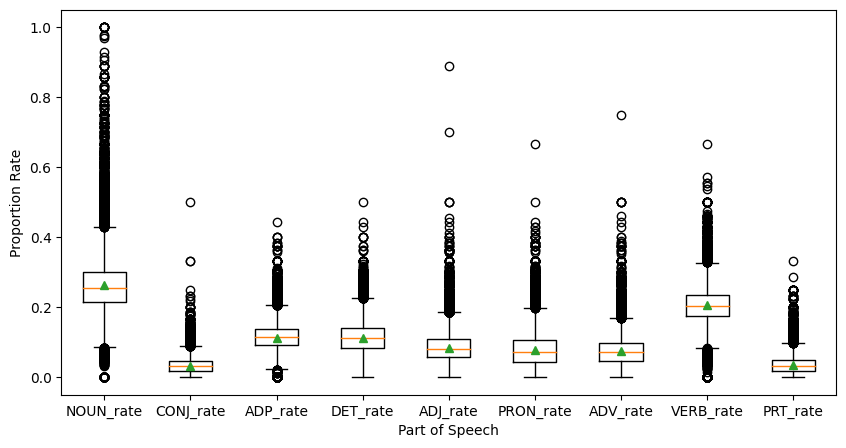

In [ ]:
import matplotlib.pyplot as plt

box1 = df_PartOfSpeech_Human['NOUN_rate']
box2 = df_PartOfSpeech_Human['CONJ_rate']
box3 = df_PartOfSpeech_Human['ADP_rate']
box4 = df_PartOfSpeech_Human['DET_rate']
box5 = df_PartOfSpeech_Human['ADJ_rate']
box6 = df_PartOfSpeech_Human['PRON_rate']
box7 = df_PartOfSpeech_Human['ADV_rate']
box8 = df_PartOfSpeech_Human['VERB_rate']
box9 = df_PartOfSpeech_Human['PRT_rate']


plt.figure(figsize=(10,5))
labels = 'NOUN_rate','CONJ_rate','ADP_rate','DET_rate','ADJ_rate','PRON_rate','ADV_rate','VERB_rate','PRT_rate'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9],labels = labels,showmeans=True)
plt.xlabel('Part of Speech')
plt.ylabel('Proportion Rate')
plt.show()

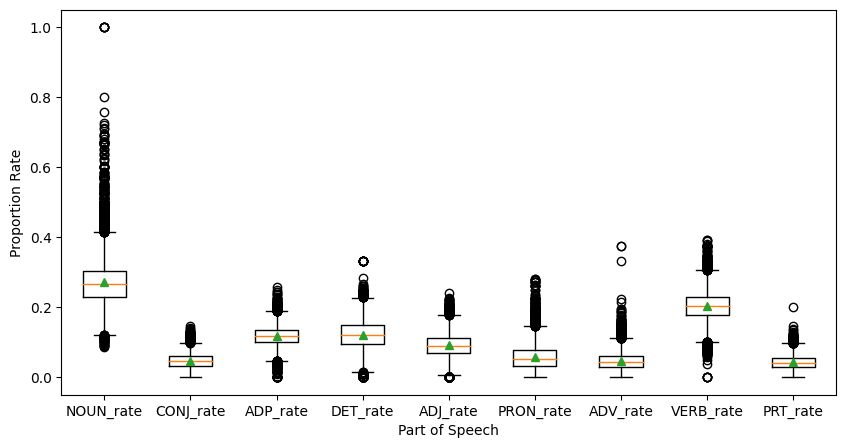

In [ ]:
box1 = df_PartOfSpeech_GPT['NOUN_rate']
box2 = df_PartOfSpeech_GPT['CONJ_rate']
box3 = df_PartOfSpeech_GPT['ADP_rate']
box4 = df_PartOfSpeech_GPT['DET_rate']
box5 = df_PartOfSpeech_GPT['ADJ_rate']
box6 = df_PartOfSpeech_GPT['PRON_rate']
box7 = df_PartOfSpeech_GPT['ADV_rate']
box8 = df_PartOfSpeech_GPT['VERB_rate']
box9 = df_PartOfSpeech_GPT['PRT_rate']

plt.figure(figsize=(10,5))
labels = 'NOUN_rate','CONJ_rate','ADP_rate','DET_rate','ADJ_rate','PRON_rate','ADV_rate','VERB_rate','PRT_rate'
plt.boxplot([box1,box2,box3,box4,box5,box6,box7,box8,box9],labels = labels,showmeans=True)
plt.xlabel('Part of Speech')
plt.ylabel('Proportion Rate')
plt.show()

In [ ]:
def predict(sent):
  test_sentence = sent.strip()
  # Preprocess the test sentence and get the predicted label
  input_ids, attention_mask = preprocess_text(
      tokenizer, test_sentence, max_length=512
  )
  predicted_label = get_prediction(model, input_ids, attention_mask)

  # Print the output based on the predicted label
  if predicted_label == 0:
      return 'human'
  else:
      return 'chatGPT'

def predict_compare(sent1,sent2):
  predict_1 = predict(sent1)
  predict_2 = predict(sent2)
  print("The orginal text's predicted result is: "+predict_1+" The modified text's predicted result is: "+predict_2)


**Word Frequency (focus on NOUN,ADJ,PRON,ADV,VERB)** 

In [ ]:
df_word_frequency_GPT = pd.DataFrame()
for text in GPT_text:
  words = nltk.word_tokenize(text)
  pos_tags = nltk.pos_tag(words,tagset='universal')
  noun_dict = {'base':0}
  adj_dict = {'base':0}
  pron_dict = {'base':0}
  adv_dict = {'base':0}
  verb_dict = {'base':0}
  for word,pos in pos_tags:
    if pos == 'NOUN':
      if word not in noun_dict:
        noun_dict[word] = 1
      else:
        noun_dict[word] += 1

    if pos == 'ADJ':
      if word not in adj_dict:
        adj_dict[word] = 1
      else:
        adj_dict[word] += 1
    
    if pos == 'PRON':
      if word not in pron_dict:
        pron_dict[word] = 1
      else:
        pron_dict[word] += 1

    if pos == 'ADV':
      if word not in adv_dict:
        adv_dict[word] = 1
      else:
        adv_dict[word] += 1

    if pos == 'VERB':
      if word not in verb_dict:
        verb_dict[word] = 1
      else:
        verb_dict[word] += 1
    

  noun_max,adj_max,pron_max,adv_max,verb_max = max(noun_dict.values()),max(adj_dict.values()),max(pron_dict.values()),max(adv_dict.values()),max(verb_dict.values())

  temp = pd.DataFrame({'NOUN':[noun_max],'ADJ':[adj_max],'PRON':[pron_max],'ADV':[adv_max],'VERB':[verb_max]})
  df_word_frequency_GPT = pd.concat([df_word_frequency_GPT,temp])

In [ ]:
df_word_frequency_GPT

,NOUN,ADJ,PRON,ADV,VERB
0,9,8,6,2,10
0,2,2,2,2,2
0,5,2,7,2,7
0,3,5,6,3,6
0,10,2,6,4,17
...,...,...,...,...,...
0,5,3,4,2,4
0,9,3,10,1,5
0,7,4,7,2,8
0,2,1,2,2,1


In [ ]:
df_word_frequency_Human = pd.DataFrame()
for text in Human_text:
  words = nltk.word_tokenize(text)
  pos_tags = nltk.pos_tag(words,tagset='universal')
  noun_dict = {'base':0}
  adj_dict = {'base':0}
  pron_dict = {'base':0}
  adv_dict = {'base':0}
  verb_dict = {'base':0}
  for word,pos in pos_tags:
    if pos == 'NOUN':
      if word not in noun_dict:
        noun_dict[word] = 1
      else:
        noun_dict[word] += 1

    if pos == 'ADJ':
      if word not in adj_dict:
        adj_dict[word] = 1
      else:
        adj_dict[word] += 1
    
    if pos == 'PRON':
      if word not in pron_dict:
        pron_dict[word] = 1
      else:
        pron_dict[word] += 1

    if pos == 'ADV':
      if word not in adv_dict:
        adv_dict[word] = 1
      else:
        adv_dict[word] += 1

    if pos == 'VERB':
      if word not in verb_dict:
        verb_dict[word] = 1
      else:
        verb_dict[word] += 1
    

  noun_max,adj_max,pron_max,adv_max,verb_max = max(noun_dict.values()),max(adj_dict.values()),max(pron_dict.values()),max(adv_dict.values()),max(verb_dict.values())

  temp = pd.DataFrame({'NOUN':[noun_max],'ADJ':[adj_max],'PRON':[pron_max],'ADV':[adv_max],'VERB':[verb_max]})
  df_word_frequency_Human = pd.concat([df_word_frequency_Human,temp])

In [ ]:
df_word_frequency_Human

,NOUN,ADJ,PRON,ADV,VERB
0,5,2,1,1,1
0,3,1,1,1,2
0,4,1,1,2,2
0,3,2,4,2,3
0,11,3,9,3,10
...,...,...,...,...,...
0,3,0,4,0,8
0,3,2,2,2,2
0,5,3,1,4,7
0,1,1,1,1,2


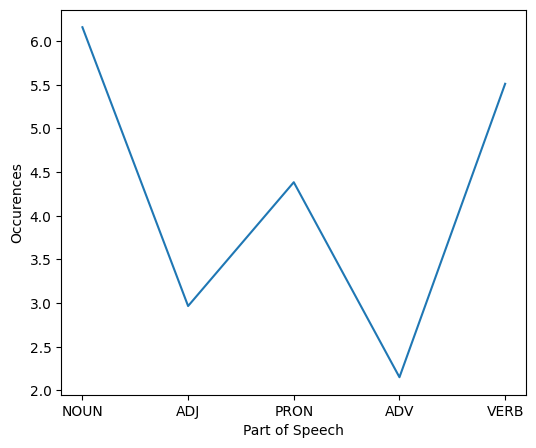

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(df_word_frequency_GPT.mean())
plt.xlabel('Part of Speech')
plt.ylabel('Occurences')
plt.show()

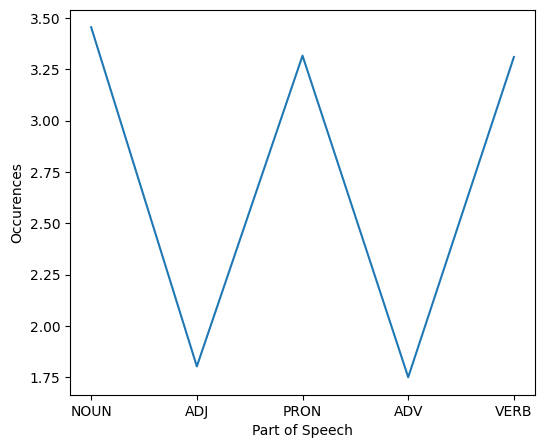

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(df_word_frequency_Human.mean())
plt.xlabel('Part of Speech')
plt.ylabel('Occurences')
plt.show()

**Attribution Analysis of Word Frequency**

In [ ]:
Word_Frequency_Attribution_GPT = pd.DataFrame()
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)

for text in GPT_text[:1000]:
  explanation = explainer(text)
  words = nltk.word_tokenize(text)
  pos_tags = nltk.pos_tag(words,tagset='universal')
  noun_dict = {'base':0}
  adj_dict = {'base':0}
  pron_dict = {'base':0}
  adv_dict = {'base':0}
  verb_dict = {'base':0}
  for word,pos in pos_tags:
    if pos == 'NOUN':
      if word not in noun_dict:
        noun_dict[word] = 1
      else:
        noun_dict[word] += 1

    if pos == 'ADJ':
      if word not in adj_dict:
        adj_dict[word] = 1
      else:
        adj_dict[word] += 1
    
    if pos == 'PRON':
      if word not in pron_dict:
        pron_dict[word] = 1
      else:
        pron_dict[word] += 1

    if pos == 'ADV':
      if word not in adv_dict:
        adv_dict[word] = 1
      else:
        adv_dict[word] += 1

    if pos == 'VERB':
      if word not in verb_dict:
        verb_dict[word] = 1
      else:
        verb_dict[word] += 1
    

  noun_max,adj_max,pron_max,adv_max,verb_max = max(noun_dict.values()),max(adj_dict.values()),max(pron_dict.values()),max(adv_dict.values()),max(verb_dict.values())
  noun,adj,pron,adv,verb = max(noun_dict, key=(lambda k: noun_dict[k])),max(adj_dict, key=(lambda k: adj_dict[k])),max(pron_dict, key=(lambda k: pron_dict[k])),max(adv_dict, key=(lambda k: adv_dict[k])),max(verb_dict, key=(lambda k: verb_dict[k]))
  
  noun_attri = 0
  adj_attri = 0
  pron_attri = 0
  adv_attri = 0
  verb_attri = 0

  for word,attri in explanation:
    if word == noun:
      noun_attri += attri
    if word == adj:
      adj_attri += attri
    if word == pron:
      pron_attri += attri
    if word == adv:
      adv_attri += attri
    if word == verb:
      verb_attri += attri

  temp = pd.DataFrame({'NOUN':[noun_max],'ADJ':[adj_max],'PRON':[pron_max],'ADV':[adv_max],'VERB':[verb_max],'Attri_NOUN':[noun_attri],'Attri_ADJ':[adj_attri],'Attri_PRON':[pron_attri],'Attri_ADV':[adv_attri],'Attri_VERB':[verb_attri]})
  Word_Frequency_Attribution_GPT = pd.concat([Word_Frequency_Attribution_GPT,temp])

In [ ]:
Word_Frequency_Attribution_GPT

,NOUN,ADJ,PRON,ADV,VERB,Attri_NOUN,Attri_ADJ,Attri_PRON,Attri_ADV,Attri_VERB
0,9,8,6,2,10,-0.181,-0.076,-0.007,-0.020,0.004
0,2,2,2,2,2,-0.133,0.177,0.113,-0.030,-0.048
0,5,2,7,2,7,-0.768,-0.034,0.171,-0.035,-0.043
0,3,5,6,3,6,0.040,0.213,0.132,-0.038,-0.153
0,10,2,6,4,17,0.204,0.004,-0.062,0.004,0.136
...,...,...,...,...,...,...,...,...,...,...
0,14,3,4,3,11,-0.041,-0.041,-0.004,0.071,0.039
0,5,2,4,2,4,-0.363,0.038,0.113,-0.149,0.011
0,6,2,1,1,5,-0.088,0.028,-0.002,-0.024,0.384
0,5,2,7,1,4,-0.256,0.738,0.049,-0.137,0.019


In [ ]:
Word_Frequency_Attribution_GPT.mean()

NOUN          6.050000
ADJ           2.865000
PRON          4.300000
ADV           2.144000
VERB          5.606000
Attri_NOUN   -0.073213
Attri_ADJ    -0.001187
Attri_PRON    0.041333
Attri_ADV     0.014364
Attri_VERB    0.008824
dtype: float64

In [ ]:
Word_Frequency_Attribution_Human = pd.DataFrame()
model_path = "/content/drive/MyDrive/best_model.pt"
tokenizer, model = load_model(model_path)

for text in Human_text[:1000]:
  explanation = explainer(text)
  words = nltk.word_tokenize(text)
  pos_tags = nltk.pos_tag(words,tagset='universal')
  noun_dict = {'base':0}
  adj_dict = {'base':0}
  pron_dict = {'base':0}
  adv_dict = {'base':0}
  verb_dict = {'base':0}
  for word,pos in pos_tags:
    if pos == 'NOUN':
      if word not in noun_dict:
        noun_dict[word] = 1
      else:
        noun_dict[word] += 1

    if pos == 'ADJ':
      if word not in adj_dict:
        adj_dict[word] = 1
      else:
        adj_dict[word] += 1
    
    if pos == 'PRON':
      if word not in pron_dict:
        pron_dict[word] = 1
      else:
        pron_dict[word] += 1

    if pos == 'ADV':
      if word not in adv_dict:
        adv_dict[word] = 1
      else:
        adv_dict[word] += 1

    if pos == 'VERB':
      if word not in verb_dict:
        verb_dict[word] = 1
      else:
        verb_dict[word] += 1
    

  noun_max,adj_max,pron_max,adv_max,verb_max = max(noun_dict.values()),max(adj_dict.values()),max(pron_dict.values()),max(adv_dict.values()),max(verb_dict.values())
  noun,adj,pron,adv,verb = max(noun_dict, key=(lambda k: noun_dict[k])),max(adj_dict, key=(lambda k: adj_dict[k])),max(pron_dict, key=(lambda k: pron_dict[k])),max(adv_dict, key=(lambda k: adv_dict[k])),max(verb_dict, key=(lambda k: verb_dict[k]))
  
  noun_attri = 0
  adj_attri = 0
  pron_attri = 0
  adv_attri = 0
  verb_attri = 0

  for word,attri in explanation:
    if word == noun:
      noun_attri += attri
    if word == adj:
      adj_attri += attri
    if word == pron:
      pron_attri += attri
    if word == adv:
      adv_attri += attri
    if word == verb:
      verb_attri += attri

  temp = pd.DataFrame({'NOUN':[noun_max],'ADJ':[adj_max],'PRON':[pron_max],'ADV':[adv_max],'VERB':[verb_max],'Attri_NOUN':[noun_attri],'Attri_ADJ':[adj_attri],'Attri_PRON':[pron_attri],'Attri_ADV':[adv_attri],'Attri_VERB':[verb_attri]})
  Word_Frequency_Attribution_Human = pd.concat([Word_Frequency_Attribution_Human,temp])

In [ ]:
Word_Frequency_Attribution_Human

,NOUN,ADJ,PRON,ADV,VERB,Attri_NOUN,Attri_ADJ,Attri_PRON,Attri_ADV,Attri_VERB
0,5,2,1,1,1,-0.093,-0.187,-0.039,0.039,0.076
0,3,1,1,1,2,-0.076,0.028,0.383,0.078,-0.092
0,4,1,1,2,2,0.473,0.134,-0.011,-0.103,0.041
0,3,2,4,2,3,-0.007,-0.131,-0.212,-0.446,0.000
0,11,3,9,3,10,0.277,0.065,0.001,0.000,-0.070
...,...,...,...,...,...,...,...,...,...,...
0,4,1,2,1,1,-0.479,-0.044,0.011,0.057,0.025
0,1,1,1,1,1,-0.090,0.066,-0.007,0.066,-0.001
0,5,1,4,2,4,0.132,0.047,0.011,0.000,-0.078
0,4,2,1,1,1,0.522,0.522,-0.149,-0.069,-0.172


In [ ]:
Word_Frequency_Attribution_Human.mean()

NOUN          3.538000
ADJ           1.814000
PRON          3.536000
ADV           1.831000
VERB          3.297000
Attri_NOUN    0.065605
Attri_ADJ     0.018359
Attri_PRON   -0.003809
Attri_ADV     0.001601
Attri_VERB   -0.028640
dtype: float64